Atividade 1 - Implementando uma rede neural recorrente em Python (Colab)

(Exercício 2 dos slides da aula) - Implementar uma solução em
Python, usando redes neurais recorrentes, capaz de estimar um ano de
temperatura do solo a partir dos dados informados para os anos anteriores. Comparar o desempenho de uma RNN simples com uma estrutura do tipo LSTM. Explicar em detalhes as principais funções/recursos empregados, bem como a configuração dos dados preparada para ser executada, como tamanho da sequencia, dimensão de entrada, dimensão de saída dos dados e dimensão do estado oculto das redes.

""
Notebook Colab: Previsão de temperatura do solo com LSTM
------------------------------------------------------
Passo-a-passo, documentado, pronto para executar no Google Colab.


Principais características:
- Monta o Google Drive e lê todos os CSVs do diretório fornecido.
- Detecta e usa as colunas: datetime(GMT) e soiltemp(F).
- Agrupa por ano (média anual), converte para °C.
- Cria sequências temporais (multi-step via predição iterativa) usando LSTM.
- Treina com callbacks (EarlyStopping, ModelCheckpoint) e plota curvas de perda.
- Avalia no conjunto de teste e gera previsões para 2024 e 2025.
- Salva modelo e scaler no Drive.


Instruções:
1. Abra um novo notebook no Colab.
2. Cole o conteúdo desta célula em uma célula de código e execute.
3. Ajuste SEQUENCE_LENGTH, EPOCHS ou caminhos conforme necessário.


"""

In [1]:
# -----------------------------------------------------------------------------
# 0) Dependências
# -----------------------------------------------------------------------------
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib

In [2]:
# -----------------------------------------------------------------------------
# 1) Configurações - ajuste conforme necessário
# -----------------------------------------------------------------------------
SEQUENCE_LENGTH = 5 # anos usados para predizer o próximo
TEST_RATIO = 0.15
VAL_RATIO = 0.15
EPOCHS = 200
BATCH_SIZE = 8
MODEL_SAVE_PATH = '/content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/soil_temp_lstm.h5'
SCALER_SAVE_PATH = '/content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/soil_temp_scaler.save'


# Colunas do arquivo de entrada
YEAR_COL = 'datetime(GMT)'
TEMP_COL = 'soiltemp(F)'


# Caminho no Drive (conforme informado)
BASE_DIR = '/content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/bases_csv'

In [3]:
# -----------------------------------------------------------------------------
# 2) Montar Google Drive (Colab) e definir caminho base
# -----------------------------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive')
print('Google Drive montado com sucesso!')


# Caminho base informado pelo usuário
base_dir = '/content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/bases_csv'
print('Diretório base definido como:', base_dir)

Mounted at /content/drive
Google Drive montado com sucesso!
Diretório base definido como: /content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/bases_csv


In [4]:
# -----------------------------------------------------------------------------
# 3) Carregar todos os CSVs e montar DataFrame único
# -----------------------------------------------------------------------------
if not os.path.isdir(BASE_DIR):
  raise FileNotFoundError(f'O diretório {BASE_DIR} não existe. Ajuste BASE_DIR.')


csv_files = glob.glob(os.path.join(BASE_DIR, '*.csv'))
print(f'Encontrados {len(csv_files)} arquivos CSV em {BASE_DIR}')
if len(csv_files) == 0:
  raise FileNotFoundError('Nenhum CSV encontrado no diretório especificado.')


dfs = []
for f in csv_files:
  df = pd.read_csv(f)
  df['_source_file'] = os.path.basename(f)
  dfs.append(df)


data = pd.concat(dfs, ignore_index=True)
print('Data concatenada shape:', data.shape)
print('Colunas:', list(data.columns))

Encontrados 15 arquivos CSV em /content/drive/MyDrive/Mestrado_PPGI/2AS2_IA_GENERATIVA/Aula 03/bases_csv
Data concatenada shape: (2011647, 13)
Colunas: ['nws_id', 'physicalelement', 'datetime(GMT)', 'sitename', 'wfo', 'latitude', 'longitude', 'soiltemp(F)', 'depth(in)', 'afos_id', 'extremum', '_source_file', 'Unnamed: 11']


In [5]:
# -----------------------------------------------------------------------------
# 4) Preparar colunas de data e temperatura (usar as colunas já identificadas)
# -----------------------------------------------------------------------------
# Converter a coluna de data e extrair ano
data[YEAR_COL] = pd.to_datetime(data[YEAR_COL], errors='coerce')
# Converter temperatura para numérico (Fahrenheit)
data['temp_F'] = pd.to_numeric(data[TEMP_COL], errors='coerce')
# Remover linhas inválidas
data = data.dropna(subset=[YEAR_COL, 'temp_F']).copy()
# Extrair ano e converter para Celsius
data['year'] = data[YEAR_COL].dt.year
data['temp_C'] = (data['temp_F'] - 32) * 5.0/9.0


# Agregar média anual
annual = data.groupby('year')['temp_C'].mean().reset_index().sort_values('year').reset_index(drop=True)
print('Anos disponíveis:', annual['year'].min(), '-', annual['year'].max())
print(annual.head())

Anos disponíveis: 2009 - 2023
   year     temp_C
0  2009   5.657196
1  2010   9.739401
2  2011   9.118551
3  2012  10.174109
4  2013   8.415860


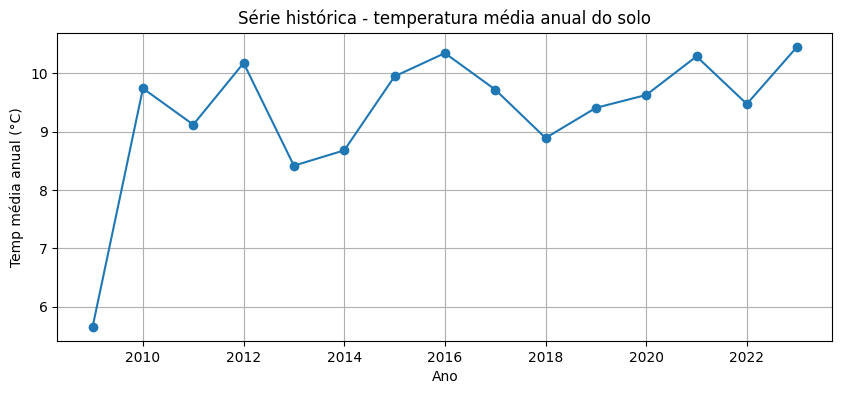

In [6]:
# -----------------------------------------------------------------------------
# 5) Visualizar série histórica e checar quantidade de anos
# -----------------------------------------------------------------------------
plt.figure(figsize=(10,4))
plt.plot(annual['year'], annual['temp_C'], marker='o')
plt.xlabel('Ano')
plt.ylabel('Temp média anual (°C)')
plt.title('Série histórica - temperatura média anual do solo')
plt.grid(True)
plt.show()


if len(annual) < SEQUENCE_LENGTH + 1:
  raise ValueError(f'Poucos anos ({len(annual)}) para formar sequências com SEQUENCE_LENGTH={SEQUENCE_LENGTH}')

In [7]:
# -----------------------------------------------------------------------------
# 6) Criar sequências (X = seq_length anos, y = próximo ano)
# -----------------------------------------------------------------------------
def create_sequences(values, seq_length):
  X, y = [], []
  for i in range(len(values) - seq_length):
    X.append(values[i:i + seq_length])
    y.append(values[i + seq_length])
  return np.array(X), np.array(y)


values = annual['temp_C'].values.astype('float32')
X_all, y_all = create_sequences(values, SEQUENCE_LENGTH)
print('Sequências geradas:', X_all.shape, y_all.shape)

Sequências geradas: (10, 5) (10,)


In [8]:
# -----------------------------------------------------------------------------
# 7) Split temporal (não embaralhar) em treino/val/test
# -----------------------------------------------------------------------------
n = len(X_all)
n_test = int(np.ceil(TEST_RATIO * n))
n_val = int(np.ceil(VAL_RATIO * n))
n_train = n - n_val - n_test


X_train = X_all[:n_train]
X_val = X_all[n_train:n_train + n_val]
X_test = X_all[n_train + n_val:]


y_train = y_all[:n_train]
y_val = y_all[n_train:n_train + n_val]
y_test = y_all[n_train + n_val:]


print(f'Treino: {len(X_train)}, Val: {len(X_val)}, Teste: {len(X_test)}')

Treino: 6, Val: 2, Teste: 2


In [9]:
# -----------------------------------------------------------------------------
# 8) Escalonar (fit no treino apenas)
# -----------------------------------------------------------------------------
scaler = StandardScaler()
scaler.fit(y_train.reshape(-1,1))


def scale_X(X):
  return scaler.transform(X.reshape(-1,1)).reshape(X.shape[0], X.shape[1], 1)


X_train_scaled = scale_X(X_train)
X_val_scaled = scale_X(X_val)
X_test_scaled = scale_X(X_test)


y_train_scaled = scaler.transform(y_train.reshape(-1,1)).reshape(-1)
y_val_scaled = scaler.transform(y_val.reshape(-1,1)).reshape(-1)
y_test_scaled = scaler.transform(y_test.reshape(-1,1)).reshape(-1)

In [10]:
# -----------------------------------------------------------------------------
# 9) Construir o modelo LSTM
# -----------------------------------------------------------------------------
model = Sequential([
  LSTM(64, input_shape=(SEQUENCE_LENGTH, 1), return_sequences=False),
  Dropout(0.2),
  Dense(32, activation='relu'),
  Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


# Callbacks
es = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
mc = ModelCheckpoint(MODEL_SAVE_PATH, monitor='val_loss', save_best_only=True)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


1/1 - 6s - 6s/step - loss: 0.9967 - mae: 0.8762 - val_loss: 0.9677 - val_mae: 0.8016
Epoch 2/200


1/1 - 0s - 214ms/step - loss: 0.9464 - mae: 0.8561 - val_loss: 0.9675 - val_mae: 0.8005
Epoch 3/200


1/1 - 0s - 221ms/step - loss: 0.9456 - mae: 0.8527 - val_loss: 0.9667 - val_mae: 0.7993
Epoch 4/200


1/1 - 0s - 228ms/step - loss: 0.9481 - mae: 0.8536 - val_loss: 0.9650 - val_mae: 0.7978
Epoch 5/200


1/1 - 0s - 118ms/step - loss: 0.9352 - mae: 0.8531 - val_loss: 0.9635 - val_mae: 0.7966
Epoch 6/200


1/1 - 0s - 115ms/step - loss: 0.9216 - mae: 0.8461 - val_loss: 0.9611 - val_mae: 0.7950
Epoch 7/200


1/1 - 0s - 117ms/step - loss: 0.9380 - mae: 0.8586 - val_loss: 0.9582 - val_mae: 0.7929
Epoch 8/200


1/1 - 0s - 114ms/step - loss: 0.9644 - mae: 0.8636 - val_loss: 0.9544 - val_mae: 0.7903
Epoch 9/200


1/1 - 0s - 118ms/step - loss: 0.9190 - mae: 0.8486 - val_loss: 0.9504 - val_mae: 0.7875
Epoch 10/200


1/1 - 0s - 114ms/step - loss: 0.8790 - mae: 0.8267 - val_loss: 0.9457 - val_mae: 0.7842
Epoch 11/200


1/1 - 0s - 135ms/step - loss: 0.8756 - mae: 0.8309 - val_loss: 0.9414 - val_mae: 0.7807
Epoch 12/200


1/1 - 0s - 118ms/step - loss: 0.8568 - mae: 0.8215 - val_loss: 0.9371 - val_mae: 0.7772
Epoch 13/200


1/1 - 0s - 132ms/step - loss: 0.8856 - mae: 0.8308 - val_loss: 0.9325 - val_mae: 0.7737
Epoch 14/200


1/1 - 0s - 116ms/step - loss: 0.8554 - mae: 0.8207 - val_loss: 0.9270 - val_mae: 0.7698
Epoch 15/200


1/1 - 0s - 121ms/step - loss: 0.8653 - mae: 0.8265 - val_loss: 0.9217 - val_mae: 0.7661
Epoch 16/200


1/1 - 0s - 123ms/step - loss: 0.8497 - mae: 0.8149 - val_loss: 0.9162 - val_mae: 0.7625
Epoch 17/200


1/1 - 0s - 119ms/step - loss: 0.8238 - mae: 0.8061 - val_loss: 0.9106 - val_mae: 0.7586
Epoch 18/200


1/1 - 0s - 124ms/step - loss: 0.8659 - mae: 0.8236 - val_loss: 0.9050 - val_mae: 0.7547
Epoch 19/200


1/1 - 0s - 141ms/step - loss: 0.8108 - mae: 0.7911 - val_loss: 0.8992 - val_mae: 0.7512
Epoch 20/200


1/1 - 0s - 120ms/step - loss: 0.7523 - mae: 0.7693 - val_loss: 0.8939 - val_mae: 0.7480
Epoch 21/200


1/1 - 0s - 120ms/step - loss: 0.7540 - mae: 0.7588 - val_loss: 0.8879 - val_mae: 0.7445
Epoch 22/200


1/1 - 0s - 121ms/step - loss: 0.7275 - mae: 0.7478 - val_loss: 0.8832 - val_mae: 0.7413
Epoch 23/200


1/1 - 0s - 123ms/step - loss: 0.7346 - mae: 0.7503 - val_loss: 0.8784 - val_mae: 0.7380
Epoch 24/200


1/1 - 0s - 126ms/step - loss: 0.7512 - mae: 0.7616 - val_loss: 0.8736 - val_mae: 0.7347
Epoch 25/200


1/1 - 0s - 136ms/step - loss: 0.7169 - mae: 0.7430 - val_loss: 0.8690 - val_mae: 0.7316
Epoch 26/200


1/1 - 0s - 138ms/step - loss: 0.6710 - mae: 0.7068 - val_loss: 0.8644 - val_mae: 0.7286
Epoch 27/200


1/1 - 0s - 141ms/step - loss: 0.6256 - mae: 0.6630 - val_loss: 0.8595 - val_mae: 0.7254
Epoch 28/200


1/1 - 0s - 124ms/step - loss: 0.6141 - mae: 0.6531 - val_loss: 0.8545 - val_mae: 0.7222
Epoch 29/200


1/1 - 0s - 136ms/step - loss: 0.5876 - mae: 0.6160 - val_loss: 0.8494 - val_mae: 0.7190
Epoch 30/200


1/1 - 0s - 132ms/step - loss: 0.6460 - mae: 0.7009 - val_loss: 0.8441 - val_mae: 0.7157
Epoch 31/200


1/1 - 0s - 122ms/step - loss: 0.5886 - mae: 0.6180 - val_loss: 0.8386 - val_mae: 0.7123
Epoch 32/200


1/1 - 0s - 122ms/step - loss: 0.5396 - mae: 0.5941 - val_loss: 0.8326 - val_mae: 0.7088
Epoch 33/200


1/1 - 0s - 123ms/step - loss: 0.5359 - mae: 0.6068 - val_loss: 0.8263 - val_mae: 0.7052
Epoch 34/200


1/1 - 0s - 127ms/step - loss: 0.5730 - mae: 0.5992 - val_loss: 0.8199 - val_mae: 0.7015
Epoch 35/200


1/1 - 0s - 120ms/step - loss: 0.5118 - mae: 0.6109 - val_loss: 0.8133 - val_mae: 0.6978
Epoch 36/200


1/1 - 0s - 120ms/step - loss: 0.4727 - mae: 0.5487 - val_loss: 0.8068 - val_mae: 0.6943
Epoch 37/200


1/1 - 0s - 119ms/step - loss: 0.5033 - mae: 0.5795 - val_loss: 0.8001 - val_mae: 0.6906
Epoch 38/200


1/1 - 0s - 123ms/step - loss: 0.4675 - mae: 0.5909 - val_loss: 0.7933 - val_mae: 0.6869
Epoch 39/200


1/1 - 0s - 145ms/step - loss: 0.4544 - mae: 0.5430 - val_loss: 0.7865 - val_mae: 0.6830
Epoch 40/200


1/1 - 0s - 122ms/step - loss: 0.4575 - mae: 0.5710 - val_loss: 0.7800 - val_mae: 0.6794
Epoch 41/200


1/1 - 0s - 128ms/step - loss: 0.4179 - mae: 0.5224 - val_loss: 0.7730 - val_mae: 0.6754
Epoch 42/200


1/1 - 0s - 129ms/step - loss: 0.4123 - mae: 0.5333 - val_loss: 0.7657 - val_mae: 0.6712
Epoch 43/200


1/1 - 0s - 118ms/step - loss: 0.3922 - mae: 0.5341 - val_loss: 0.7581 - val_mae: 0.6670
Epoch 44/200


1/1 - 0s - 121ms/step - loss: 0.4145 - mae: 0.5615 - val_loss: 0.7483 - val_mae: 0.6608
Epoch 45/200


1/1 - 0s - 124ms/step - loss: 0.3971 - mae: 0.5455 - val_loss: 0.7370 - val_mae: 0.6534
Epoch 46/200


1/1 - 0s - 120ms/step - loss: 0.3551 - mae: 0.4825 - val_loss: 0.7252 - val_mae: 0.6455
Epoch 47/200


1/1 - 0s - 117ms/step - loss: 0.3436 - mae: 0.5046 - val_loss: 0.7140 - val_mae: 0.6383
Epoch 48/200


1/1 - 0s - 128ms/step - loss: 0.3072 - mae: 0.4274 - val_loss: 0.7021 - val_mae: 0.6305
Epoch 49/200


1/1 - 0s - 118ms/step - loss: 0.4177 - mae: 0.5380 - val_loss: 0.6902 - val_mae: 0.6228
Epoch 50/200


1/1 - 0s - 134ms/step - loss: 0.3203 - mae: 0.4793 - val_loss: 0.6790 - val_mae: 0.6156
Epoch 51/200


1/1 - 0s - 118ms/step - loss: 0.3015 - mae: 0.4868 - val_loss: 0.6685 - val_mae: 0.6092
Epoch 52/200


1/1 - 0s - 133ms/step - loss: 0.2661 - mae: 0.4324 - val_loss: 0.6587 - val_mae: 0.6034
Epoch 53/200


1/1 - 0s - 124ms/step - loss: 0.2975 - mae: 0.4679 - val_loss: 0.6506 - val_mae: 0.5992
Epoch 54/200


1/1 - 0s - 124ms/step - loss: 0.2427 - mae: 0.4056 - val_loss: 0.6404 - val_mae: 0.5931
Epoch 55/200


1/1 - 0s - 119ms/step - loss: 0.2208 - mae: 0.3654 - val_loss: 0.6309 - val_mae: 0.5878
Epoch 56/200


1/1 - 0s - 123ms/step - loss: 0.2358 - mae: 0.3750 - val_loss: 0.6223 - val_mae: 0.5832
Epoch 57/200


1/1 - 0s - 119ms/step - loss: 0.2044 - mae: 0.3813 - val_loss: 0.6114 - val_mae: 0.5767
Epoch 58/200


1/1 - 0s - 131ms/step - loss: 0.2115 - mae: 0.3814 - val_loss: 0.5987 - val_mae: 0.5684
Epoch 59/200


1/1 - 0s - 121ms/step - loss: 0.1686 - mae: 0.3456 - val_loss: 0.5885 - val_mae: 0.5626
Epoch 60/200


1/1 - 0s - 124ms/step - loss: 0.2036 - mae: 0.3694 - val_loss: 0.5807 - val_mae: 0.5591
Epoch 61/200


1/1 - 0s - 125ms/step - loss: 0.1323 - mae: 0.2868 - val_loss: 0.5740 - val_mae: 0.5566
Epoch 62/200


1/1 - 0s - 144ms/step - loss: 0.1210 - mae: 0.2816 - val_loss: 0.5674 - val_mae: 0.5543
Epoch 63/200


1/1 - 0s - 125ms/step - loss: 0.2192 - mae: 0.4245 - val_loss: 0.5558 - val_mae: 0.5464
Epoch 64/200


1/1 - 0s - 122ms/step - loss: 0.1287 - mae: 0.2715 - val_loss: 0.5448 - val_mae: 0.5390
Epoch 65/200


1/1 - 0s - 132ms/step - loss: 0.1079 - mae: 0.2391 - val_loss: 0.5356 - val_mae: 0.5336
Epoch 66/200


1/1 - 0s - 134ms/step - loss: 0.0905 - mae: 0.2389 - val_loss: 0.5289 - val_mae: 0.5308
Epoch 67/200
1/1 - 0s - 76ms/step - loss: 0.2093 - mae: 0.3664 - val_loss: 0.5322 - val_mae: 0.5383
Epoch 68/200
1/1 - 0s - 77ms/step - loss: 0.1033 - mae: 0.2677 - val_loss: 0.5394 - val_mae: 0.5495
Epoch 69/200
1/1 - 0s - 82ms/step - loss: 0.0746 - mae: 0.2337 - val_loss: 0.5483 - val_mae: 0.5614
Epoch 70/200
1/1 - 0s - 77ms/step - loss: 0.1745 - mae: 0.3559 - val_loss: 0.5501 - val_mae: 0.5656
Epoch 71/200
1/1 - 0s - 75ms/step - loss: 0.0985 - mae: 0.2745 - val_loss: 0.5504 - val_mae: 0.5682
Epoch 72/200
1/1 - 0s - 79ms/step - loss: 0.0922 - mae: 0.2742 - val_loss: 0.5482 - val_mae: 0.5683
Epoch 73/200
1/1 - 0s - 138ms/step - loss: 0.0679 - mae: 0.1981 - val_loss: 0.5500 - val_mae: 0.5721
Epoch 74/200
1/1 - 0s - 79ms/step - loss: 0.0898 - mae: 0.2662 - val_loss: 0.5561 - val_mae: 0.5793
Epoch 75/200
1/1 - 0s - 71ms/step - loss: 0.0689 - mae: 0.2394 - val_loss: 0.5596 - val_mae: 0.5841
Epoch 76/20

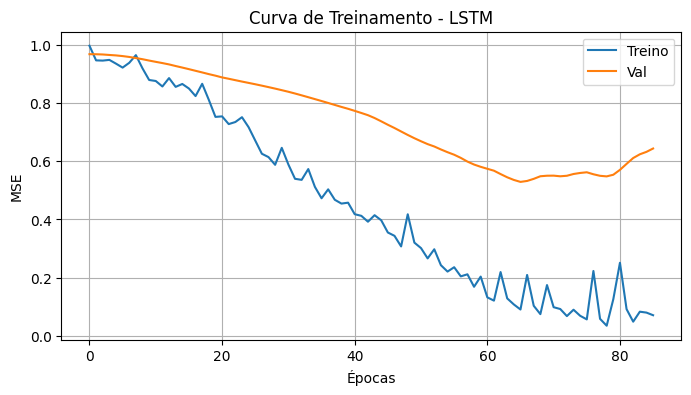

In [11]:
# -----------------------------------------------------------------------------
# 10) Treinar
# -----------------------------------------------------------------------------
history = model.fit(
X_train_scaled, y_train_scaled,
validation_data=(X_val_scaled, y_val_scaled),
epochs=EPOCHS,
batch_size=BATCH_SIZE,
callbacks=[es, mc],
verbose=2
)


# Plot de perdas
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Val')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.title('Curva de Treinamento - LSTM')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Test RMSE: 0.733 °C | MAE: 0.546 °C


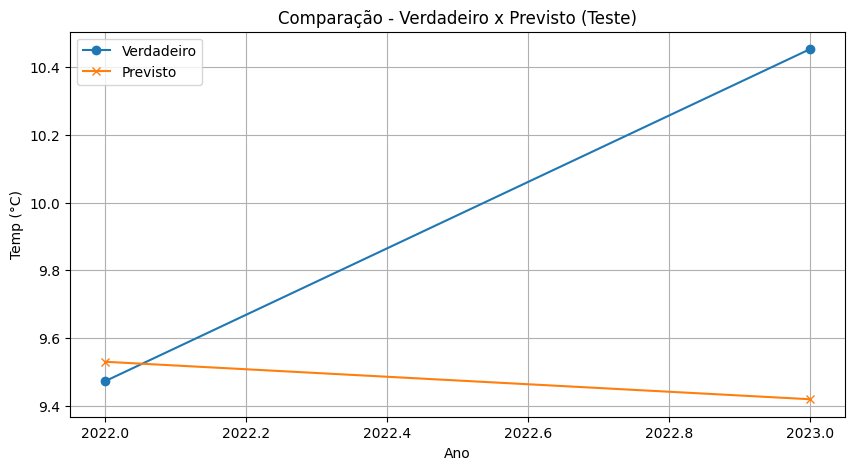

In [12]:
# -----------------------------------------------------------------------------
# 11) Avaliar no teste
# -----------------------------------------------------------------------------
pred_test_scaled = model.predict(X_test_scaled).reshape(-1,1)
pred_test = scaler.inverse_transform(pred_test_scaled).reshape(-1)


rmse = np.sqrt(mean_squared_error(y_test, pred_test))
mae = mean_absolute_error(y_test, pred_test)
print(f'Test RMSE: {rmse:.3f} °C | MAE: {mae:.3f} °C')


# Plot comparação
years_for_y = annual['year'].values[SEQUENCE_LENGTH + n_train + n_val: SEQUENCE_LENGTH + n_train + n_val + len(y_test)]
plt.figure(figsize=(10,5))
plt.plot(years_for_y, y_test, marker='o', label='Verdadeiro')
plt.plot(years_for_y, pred_test, marker='x', label='Previsto')
plt.xlabel('Ano')
plt.ylabel('Temp (°C)')
plt.title('Comparação - Verdadeiro x Previsto (Teste)')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Previsão 2024: 9.41 °C
Previsão 2025: 9.48 °C


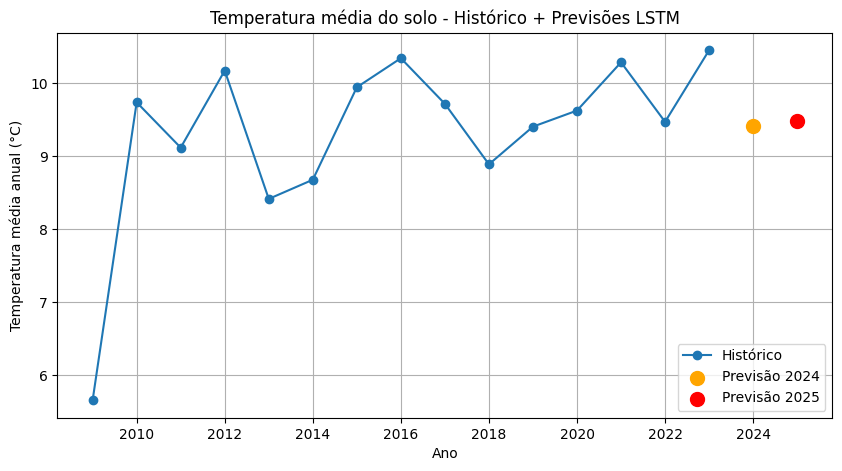

Modelo e scaler salvos no Drive.


In [26]:
# -----------------------------------------------------------------------------
# 12) Predição iterativa para 2024 e 2025 + gráfico
# -----------------------------------------------------------------------------
last_seq = values[-SEQUENCE_LENGTH:]

# Prever 2024
pred_2024_scaled = model.predict(scaler.transform(last_seq.reshape(-1,1)).reshape(1, SEQUENCE_LENGTH, 1))
pred_2024 = scaler.inverse_transform(pred_2024_scaled.reshape(-1,1)).reshape(-1)[0]

# Prever 2025 usando previsão de 2024
seq_for_2025 = np.append(last_seq[1:], pred_2024)
pred_2025_scaled = model.predict(scaler.transform(seq_for_2025.reshape(-1,1)).reshape(1, SEQUENCE_LENGTH, 1))
pred_2025 = scaler.inverse_transform(pred_2025_scaled.reshape(-1,1)).reshape(-1)[0]

print(f'Previsão 2024: {pred_2024:.2f} °C')
print(f'Previsão 2025: {pred_2025:.2f} °C')

# Plot da série histórica + previsões
plt.figure(figsize=(10,5))
plt.plot(annual['year'], annual['temp_C'], marker='o', label='Histórico')
plt.scatter(2024, pred_2024, color='orange', label='Previsão 2024', s=100, zorder=5)
plt.scatter(2025, pred_2025, color='red', label='Previsão 2025', s=100, zorder=5)
plt.xlabel('Ano')
plt.ylabel('Temperatura média anual (°C)')
plt.title('Temperatura média do solo - Histórico + Previsões LSTM')
plt.legend()
plt.grid(True)
plt.show()

# Salvar modelo e scaler
model.save(MODEL_SAVE_PATH)
joblib.dump(scaler, SCALER_SAVE_PATH)
print('Modelo e scaler salvos no Drive.')